# Assignment 2
## Fourier-based Alignment and Scale-Space Blob
### Emmanuel Gallegos
### CS 543 - Computer Vision
### UIUC
### 9/24/2022

In [160]:
# imports
import os
import cv2
import time
import numpy as np
from scipy import ndimage
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

## Part 1: Fourier-based color channel alignment

In [19]:
### useful constants
UP=0
RIGHT=1
DOWN=2
LEFT=3

BLUE=0
GREEN=1
RED=2

COLOR_1 = RED
COLOR_2 = GREEN
COLOR_DEF = BLUE

CROP_AMOUNT = 50

In [20]:
# set image paths
basic_img_dir = os.path.join(os.getcwd(), "data")
hires_img_dir = os.path.join(os.getcwd(), "data_hires")
basic_img_paths = [os.path.join(basic_img_dir, img_path) for img_path in os.listdir(basic_img_dir)]
hires_img_paths = [os.path.join(hires_img_dir, img_path) for img_path in os.listdir(hires_img_dir)]
# make directory for colorized photos if it does not exist
basic_colorized_dir = os.path.join(basic_img_dir, "..", "basic_colorized")
hires_colorized_dir = os.path.join(hires_img_dir, "..", "hires_colorized")
if not os.path.exists(basic_colorized_dir):
    os.mkdir(basic_colorized_dir)
if not os.path.exists(hires_colorized_dir):
    os.mkdir(hires_colorized_dir)
basic_colorized_paths = [os.path.join(basic_colorized_dir, img_path) for img_path in os.listdir(basic_img_dir)]
hires_colorized_paths = [os.path.join(hires_colorized_dir, img_path) for img_path in os.listdir(hires_img_dir)]
print(basic_img_paths)
print(hires_img_paths)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(basic_colorized_paths)
print(hires_colorized_paths)

['D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data\\00125v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data\\00149v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data\\00153v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data\\00351v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data\\00398v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data\\01112v.jpg']
['D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data_hires\\01047u.tif', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data_hires\\01657u.tif', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data_hires\\01861a.tif']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
['D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data\\..\\basic_colorized\\00125v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data\\..\\basic_colorized\\00149v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data\\..\\basic_colorized\\00153v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP2\\data\\..\\basic_colorized\\0035

In [162]:
# roll a 2d image in a given direction (0->up, 1->right, 2->down, 3->left)
def roll_image(image, direction, n_pixels):
    if direction == UP:
        return np.roll(image, -n_pixels, axis=0)
    elif direction == DOWN:
        return np.roll(image, n_pixels, axis=0)
    elif direction == RIGHT:
        return np.roll(image, n_pixels, axis=1)
    elif direction == LEFT:
        return np.roll(image, -n_pixels, axis=1)
    
# performs actual alignment of 3 grayscale images into rgb image based on best displacements for two colors
def align_bgr_image(bgr_image, best_col_1_disp, best_col_2_disp):    
    # roll original color 1 and color 2 images to optimal displacements
    bgr_image[COLOR_1] = roll_image(bgr_image[COLOR_1], DOWN, best_col_1_disp[0])
    bgr_image[COLOR_1] = roll_image(bgr_image[COLOR_1], RIGHT, best_col_1_disp[1])
    bgr_image[COLOR_2] = roll_image(bgr_image[COLOR_2], DOWN, best_col_2_disp[0])
    bgr_image[COLOR_2] = roll_image(bgr_image[COLOR_2], RIGHT, best_col_2_disp[1])   
    return bgr_image

# transforms bgr channels (shape 3,rows,cols) to rgb image (shape rows, cols, 3)
def bgr_channels_to_rgb_image(bgr_channels):
    # change stride from (3,r,c) to (r,c,3)
    bgr_image = bgr_channels.transpose(1,2,0)
    # flip channels from bgr to rgb channels
    rgb_image = np.flip(bgr_image, axis=-1)
    return rgb_image

# inverts the above transformation
def rgb_image_to_bgr_channels(rgb_image):
    bgr_image = np.flip(rgb_image, axis=-1)
    bgr_channels = bgr_image.transpose(2,0,1)
    return bgr_channels

# takes array of 3 grayscale images and normalizes each one to mean 0, unit norm
def normalize_image(bgr_image):
    # save shape of channel
    original_shape = bgr_image.shape
    # unroll the channels to 1d arrays
    unrolled_channels = bgr_image.reshape(3,-1)
    # get channel means
    means = np.mean(unrolled_channels, axis=1).reshape(-1,1)
    # subtract channel means to get mean 0 channels
    mean_0_channels = unrolled_channels - means
    # get channel norms
    norms = np.linalg.norm(mean_0_channels, axis=1).reshape(-1,1)
    # normalize channels
    norm_channels = mean_0_channels / norms  
    # reshape normalized arrays to original shape
    return norm_channels.reshape(original_shape)

# returns alignment indices (row, col) for grayscale images
def get_alignment_indices(channels, color1, color2):
    # timing
    start_time = time.time()
    
    # fix the sigma paramater
    col_1 = ndimage.gaussian_laplace(channels[color1], 3)
    col_2 = ndimage.gaussian_laplace(channels[color2], 3)    
    
    FT1 = np.fft.fftshift(np.fft.fft2(col_1))
    FT2 = np.fft.fftshift(np.fft.fft2(col_2))
    FT2C = np.conjugate(FT2)
    prod = np.multiply(FT1, FT2C)
    inv_FFT = np.fft.ifft2(prod)
    normed_FFT = np.log(np.abs(inv_FFT))
    
    max_index = np.unravel_index(normed_FFT.argmax(), normed_FFT.shape)
    
    # timing
    end_time = time.time()
    total_time = end_time - start_time
    
    print("Alignment time: " + str(total_time))
    
    # display
    plt.set_cmap('Spectral')
    plt.axis('off')
    plt.imshow(normed_FFT)
    
    # print displacement
    print("best color displacement: " + str(max_index))
    
    return (max_index)

## Low-Res Images

D:\HDD_Documents\UIUC\Fall_2022\CV\MP2\data\00125v.jpg
Alignment time: 0.020512104034423828
best color displacement: (13, 398)
Alignment time: 0.020519256591796875
best color displacement: (7, 399)
D:\HDD_Documents\UIUC\Fall_2022\CV\MP2\data\00149v.jpg
Alignment time: 0.02900242805480957
best color displacement: (11, 1)
Alignment time: 0.029999494552612305
best color displacement: (5, 1)
D:\HDD_Documents\UIUC\Fall_2022\CV\MP2\data\00153v.jpg
Alignment time: 0.031000375747680664
best color displacement: (16, 3)
Alignment time: 0.030997514724731445
best color displacement: (5, 2)
D:\HDD_Documents\UIUC\Fall_2022\CV\MP2\data\00351v.jpg
Alignment time: 0.020000934600830078
best color displacement: (15, 0)
Alignment time: 0.02099919319152832
best color displacement: (5, 0)
D:\HDD_Documents\UIUC\Fall_2022\CV\MP2\data\00398v.jpg
Alignment time: 0.03000020980834961
best color displacement: (14, 396)
Alignment time: 0.029999494552612305
best color displacement: (7, 396)
D:\HDD_Documents\UIUC\Fal

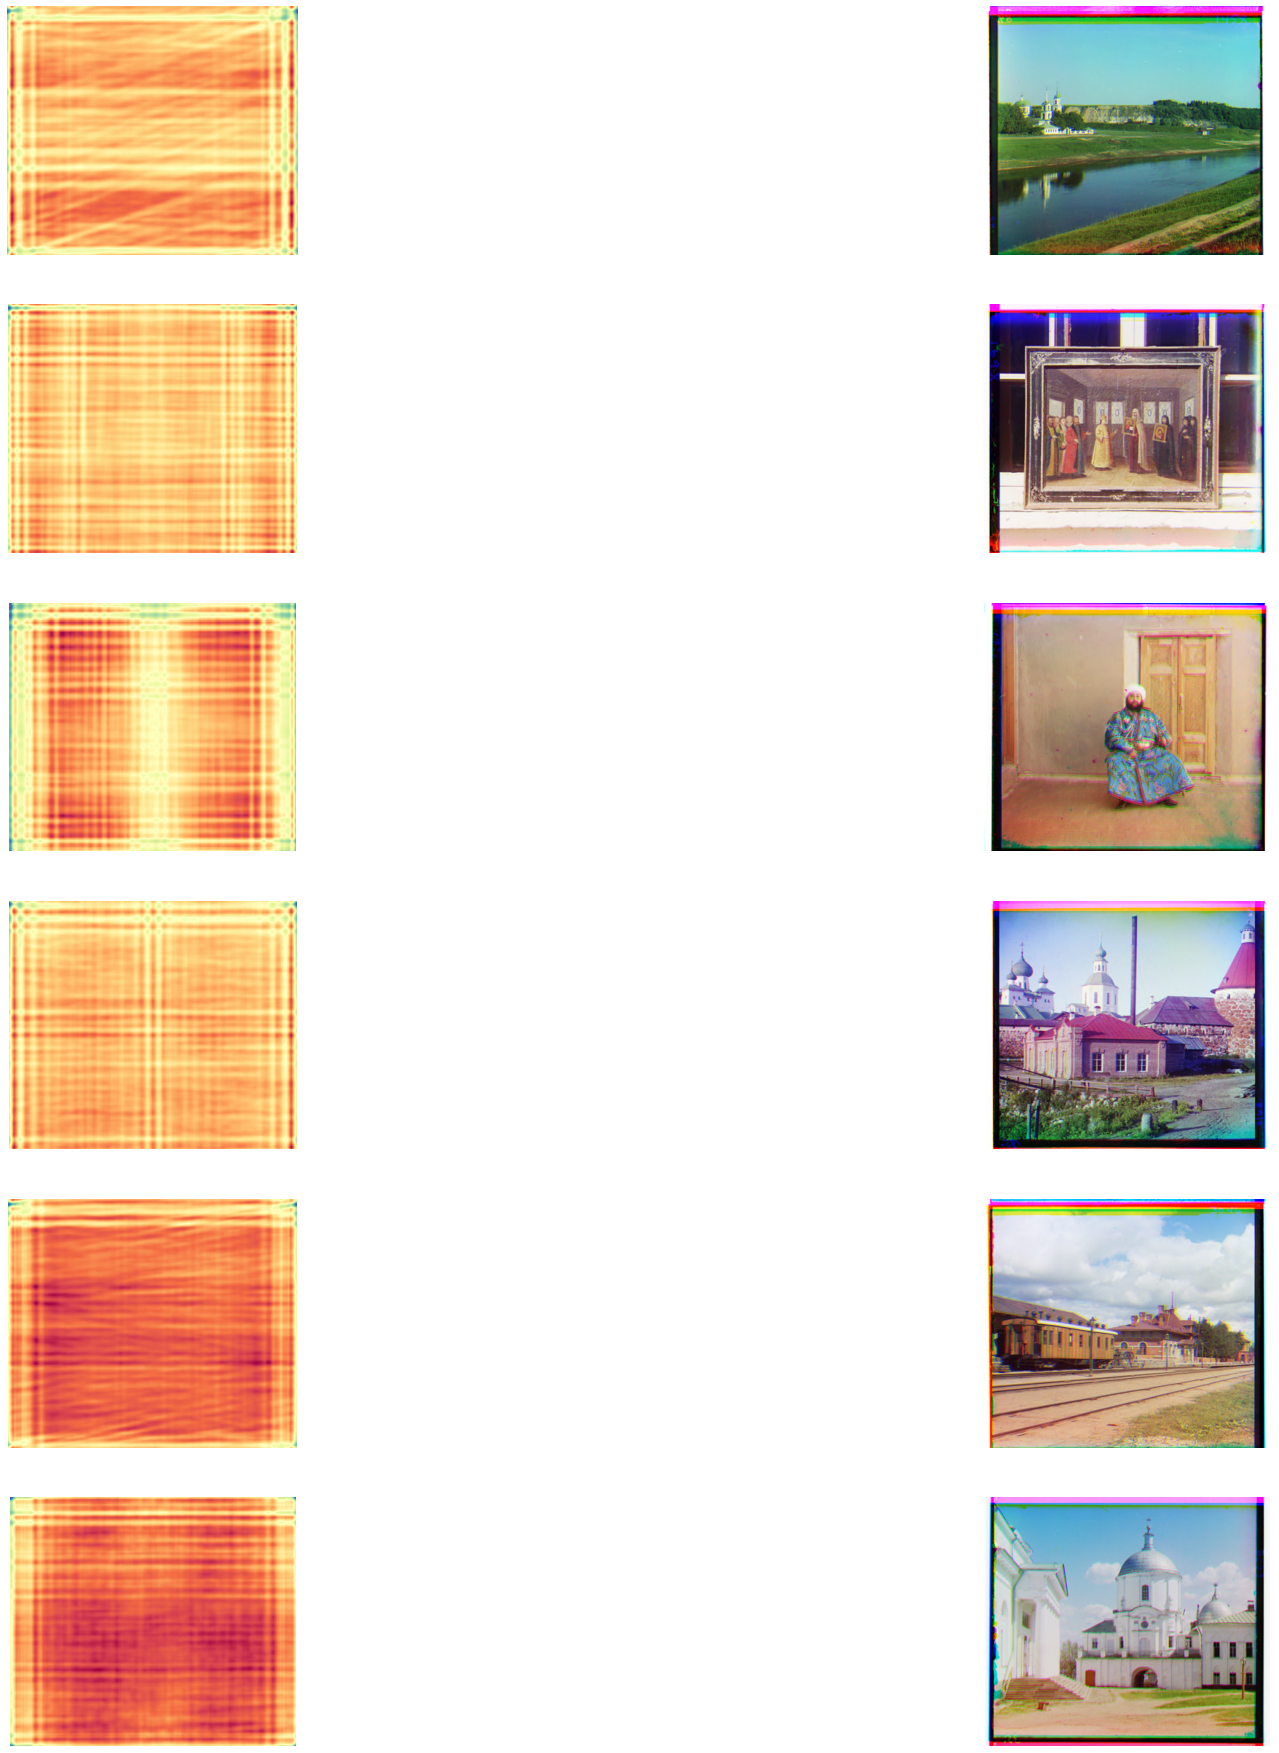

In [165]:
# create figure
fig = plt.figure(figsize=(32, 32))
rows = 6
columns = 2

for n in range (0,len(basic_img_paths)):   
    # add subplot for fft image
    fig.add_subplot(rows, columns, 2*n+1)
    # print path for debug
    print(basic_img_paths[n])
    # open image
    image = Image.open(basic_img_paths[n])
    grayscale_img = image.convert("L")
    # image to numpy array
    np_img = np.array(image)
    # ensure n_rows is multiple of 3
    while np_img.shape[0] % 3 != 0:
        np_img = np.pad(np_img, ((0,1),(0,0)), mode='constant', constant_values=255)
    # get 3 channel images
    bgr_channels = np.array(np.array_split(np_img, 3))
    # get alignment indices
    alignment_indices = get_alignment_indices(np.copy(bgr_channels), COLOR_DEF, COLOR_1), get_alignment_indices(np.copy(bgr_channels), COLOR_DEF, COLOR_2)
    # align image
    aligned_image = align_bgr_image(bgr_channels, alignment_indices[0], alignment_indices[1])
    # transform to rbg image
    rgb_image = bgr_channels_to_rgb_image(aligned_image)
    # add subplot for aligned image
    fig.add_subplot(rows, columns, 2*n+2)
    plt.axis('off')
    plt.imshow(rgb_image)
    # save image
    im = Image.fromarray(rgb_image)
    im.save(basic_colorized_paths[n])

In [ ]:
# create figure
fig = plt.figure(figsize=(32, 32))
rows = 3
columns = 2

for n in range (0,len(hires_img_paths)):   
    # add subplot for fft image
    fig.add_subplot(rows, columns, 2*n+1)
    # print path for debug
    print(hires_img_paths[n])
    # open image
    image = Image.open(hires_img_paths[n])
    grayscale_img = image.convert("L")
    # image to numpy array
    np_img = np.array(image)
    # ensure n_rows is multiple of 3
    while np_img.shape[0] % 3 != 0:
        np_img = np.pad(np_img, ((0,1),(0,0)), mode='constant', constant_values=255)
    # get 3 channel images
    bgr_channels = np.array(np.array_split(np_img, 3))
    
    # get alignment indices
    alignment_indices = get_alignment_indices(np.copy(bgr_channels), COLOR_DEF, COLOR_1), get_alignment_indices(np.copy(bgr_channels), COLOR_DEF, COLOR_2)
    
    # align image
    aligned_image = align_bgr_image(bgr_channels, alignment_indices[0], alignment_indices[1])
    # transform to rbg image
    rgb_image = bgr_channels_to_rgb_image(aligned_image)
    # to values between 0 and 255
    rgb_image = ((rgb_image / np.max(rgb_image)) * 255).astype(np.uint8)
    # add subplot for aligned image
    fig.add_subplot(rows, columns, 2*n+2)
    plt.axis('off')
    plt.imshow(rgb_image)
    # save image
    im = Image.fromarray(rgb_image)
    im.save(hires_colorized_paths[n])

D:\HDD_Documents\UIUC\Fall_2022\CV\MP2\data_hires\01047u.tif
Alignment time: 3.5260024070739746
best color displacement: (74, 32)
Alignment time: 3.5300004482269287
best color displacement: (26, 20)
D:\HDD_Documents\UIUC\Fall_2022\CV\MP2\data_hires\01657u.tif
Alignment time: 3.9740004539489746
best color displacement: (121, 10)
